### Get distance_from_others data from combined_replicates/

In [454]:
# Imports
import json
import numpy as np
import plotly.plotly as py
import matplotlib as mpl
# mpl.use('Agg')
%matplotlib inline
from matplotlib import cycler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import os
import glob2
import re

In [423]:
with open("combined_replicates/Q0.01_W0.005_D0.05_T0.001.json", "r") as f:
    data = json.load(f)

In [424]:
len(data[0]["Replicate 1"]["distance_from_others"])

8160

In [425]:
len(data)

2

### Get distances to 49 others for 1 bee over 160 timesteps

In [426]:
def get_data_1_bee(data, replicate_i, bee_start_i):
    # Loop over 50 lists in 1 timestep
    # Each list is 1 bee and its distance to 49 other bees at this timestep
    # List of 160 lists, each list has 50 values
    one_bee_160_t = []
    # Loop over 160 timesteps here
    for bee in range(bee_start_i, 8160, 51):  # for other bees: every 101?
        dist_to_49_others = data[replicate_i]["Replicate {}".format(replicate_i+1)]["distance_from_others"][bee]["distances"]
        one_bee_160_t.append(dist_to_49_others)

    return one_bee_160_t
    # bees_dict["Bee {}".format(i+1)] = dist_to_49_others

In [427]:
# Test function
# print(len(one_bee_160_t))
# print(one_bee_160_t)
bee_over_time = get_data_1_bee(data, 0, 0)
print(len(bee_over_time))
# bee_over_time[0]

160


### Threshold nearest neighbors at max = 2 distance units 

In [428]:
def get_avg_neighbor_distances(data_list):
    # Loop over each timestep list
    # List of 160 floats for 1 bee
    nearest_neighbors = []

    for t_list in data_list:
        # 160 avg values for distance to nearest neighbors
        avg_list = []
        for val in t_list:
            if val <= 2:
                avg_list.append(val)
                # print(val)
        nearest_neighbors.append(np.mean(avg_list))

    return nearest_neighbors

In [467]:
# Test
# get_avg_neighbor_distances(bee_over_time)

### Use get_data_1_bee & get_avg_neighbor_distances to get 50 lists for 50 bees -- in 1 replicate  -- later average over all 10 replicates

In [430]:
def get_distances_50_bees(data, replicate_i):
    # List of 50 lists 
    neighbor_distances_all_bees = [] 

    for i in range(51):
        # print(i)
        one_bee = get_data_1_bee(data, replicate_i, i)
        avg_distances = get_avg_neighbor_distances(one_bee)
        neighbor_distances_all_bees.append(avg_distances)
        
    return neighbor_distances_all_bees

In [431]:
# Test
# get_distances_50_bees(data, 1)

In [432]:
def all_bees_all_time(data, replicate_i):
    ''' For 1 replicate swarm, get list of all bees avg distance
    from nearest neighbors over all 160 timesteps '''

    # Avg over all 50 bees for each of 160 timesteps
    # Get a list of 160 values
    all_distances = get_distances_50_bees(data, replicate_i)

    all_bees_over_time = []
    for i in range(160):
        # For each timestep, i, get values of each of the 50 bees at that i 
        one_t = [item[i] for item in all_distances]
        # Get the avg of of all bees at the timestep
        avg_all_bees = np.mean(one_t)
        all_bees_over_time.append(avg_all_bees)
        
    return all_bees_over_time

In [468]:
# Test
# all_bees_all_time(data, 0)

### Average over all replicates in JSON

In [434]:
# Get all replicates' lists into a list
all_replicates = []
for i in range(len(data)):
    one_replicate_data = all_bees_all_time(data, i)
    all_replicates.append(one_replicate_data)

In [435]:
# Store means of 10 replicates
all_reps_avgs = []

# Also get min and max for range in plotting 
mins = []; maxes = []

for i in range(160):
    one_timestep = [item[i] for item in all_replicates]
    # Get the avg of of all bees at the timestep
    avg_all_reps_all_bees = np.mean(one_timestep)
    min_val = min(one_timestep)
    max_val = max(one_timestep)
    
    all_reps_avgs.append(avg_all_reps_all_bees)
    mins.append(min_val)
    maxes.append(max_val)


In [436]:
def avg_all_replicates(data_json):
    # Get all replicates' lists into a list
    all_replicates = []
    for i in range(len(data_json)):
        one_replicate_data = all_bees_all_time(data_json, i)
        all_replicates.append(one_replicate_data)
        
    # Store means of 10 replicates
    all_reps_avgs = []

    # Also get min and max for range in plotting 
    mins = np.min(all_replicates, axis=0)
    maxs = np.max(all_replicates, axis=0)
    
    data = {
        "_all" : all_replicates,
        "_min" : mins,
        "_max" : maxs
    }

    return data

In [449]:
SIM_DATA = False

In [450]:
if SIM_DATA:
    real_seed = np.array(avg_all_replicates(data)["_all"])
    all_data = np.array([[ele + np.random.uniform(-0.05, .05) for ele in real_seed[np.random.randint(real_seed.shape[0])]] for _ in range(10)])
    min_data = np.min(new_data, axis=0)
    max_data = np.max(new_data, axis=0)
    
    _data = {"_all" : all_data, "_min" : min_data, "_max" : max_data}
else:
    _data = avg_all_replicates(data)
    

- Colorbrewer: http://colorbrewer2.org/#type=sequential&scheme=YlGnBu&n=5
- tsplot: https://seaborn.pydata.org/generated/seaborn.tsplot.html

In [519]:
def plot_me(_all, _min, _max):
    fig, ax = plt.subplots(1, figsize=(8, 5))
    sns.set(font_scale = 1.5)
    sns.set_style("whitegrid", {'axes.grid' : False})
    
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)

    # sns.set_style("whitegrid")
    
    # Setup minmax bounds
    ax.plot(_min, color='#2c7fb8', alpha=0.)
    ax.plot(_max, color='#41b6c4', alpha=0.)
    
    # Fill between minmax bounds
    ax.fill_between([i for i in range(len(_min))], _min, _max, 
                    where = _max >= _min, facecolor='#ffffcc', alpha=0.1, interpolate=True)

    # Average with stds 68 and 95
    g = sns.tsplot(data=_all, estimator=np.mean, color="#253494", alpha=0.8, ci=[68, 95], ax=ax, err_kws={"color" : "#a1dab4", "alpha" : 0.25})
    g.lines[2].set_linewidth(3)
    g.set(ylim=(0,2))
    

    
    ax.set(xlabel='Time', ylabel='Distance')
    plt.title("Distance between workers over time \n (Q0.01_W0.005_D0.05_T0.001)")
    
    

/Users/dieumynguyen/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



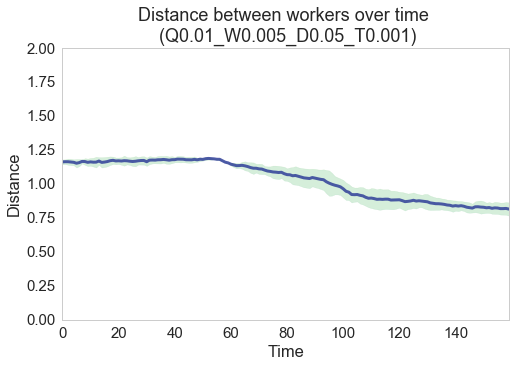

In [520]:
plot_me(**_data)